In [1]:
# Modulos básicos
import numpy as np
import time
#from pylab import imshow
import matplotlib.pyplot as plt
from tqdm import tqdm, tnrange, tqdm_notebook
# Modulo para manejo de fecha
from datetime import datetime, timedelta
# Modulos para astrofisica/solar
import astropy
from sunpy.net import vso
import astropy.units as u
from sunpy.map import Map
from astropy.io import fits # to fix headers
# Custom-made methods and classes for fixing headers
from lib.CompatMaps import sinehpc_wcs_frame_mapping

# Obtener los datos
Se usa el cliente VSO de SunPy para obtener los datos automáticamente, solo se tienen que cambiar las fechas correspondientes. Fechas de interés para el proyecto son:
* 2011/02/12 a 2011/02/17
* 2012/01/23 a 2012/01/28
* 2013/03/04 a 2013/03/09
* 2014/09/23 a 2013/09/28
* 2015/09/03 a 2015/09/08
* 2016/03/11 a 2016/03/16

Data is acquired using another jupyter notebook that is in the same repository as this one (check https://github.com/ijpulidos/solar-physics-ex/) and it's called Acquiring_Data.ipynb

The structure of the data sets stored is as follows (relative to the directory of this notebook):

PONER ACÁ LA ESTRUCTURA DE DIRECTORIOS DE DATOS

# Arreglando headers de archivos FITS descargados
Desafortunadamente para ver los resultados hay muchas imágenes que no tienen los headers correctos, entonces es necesario hacer algo como lo que se muestra en este enlace para corregir estos problemas: http://docs.sunpy.org/en/latest/generated/gallery/gallery/hmi_synoptic_maps.html and specially the updated example in: https://gist.github.com/Cadair/cbc73dc7888b9bae5d06708270aedd68

In [2]:
basepath = !pwd
fits_files = !ls data/set1/*.fits  # Quedan con el path data/*.fits 
np.shape(fits_files)

(138,)

In [ ]:
#from IPython.display import clear_output
# Read header and data from all fits files programatically
#i = 0  # index for files
for file in fits_files:
    fitsfile = fits.open(basepath[0]+'/'+file)
    fitsfile.verify('fix')
    header = fitsfile[1].header
    del fitsfile
    #time.sleep(1)
    #header.values

In [ ]:
# Fixing headers programatically
for file in tqdm_notebook(fits_files):
    print(file)
    fitsfile = fits.open(basepath[0]+'/data/'+file)
    fitsfile.verify('fix')
    header = (fitsfile[0].header)
    if header['CUNIT2'] == 'sin(latitude)' and header['CTYPE1'] == 'CRLN-CEA' and header['CTYPE2'] == 'CRLT-CEA':
        tqdm.write("Wrong header information found in %s. Changing..." % file)
        #print("Wrong header information found in %s. Changing..." % file)
        header['CUNIT2'] = 'deg'
        header['CTYPE1'] == 'CSLN-CEA'
        header['CTYPE2'] == 'CSLT-CEA'
    try:
        if header['HGLN_OBS'] == 'nan':
            del header['HGLN_OBS']
    except KeyError:
        #tdqm.write("Warning: Key not found, letting it pass.")
        print("Warning: Key not found, letting it pass.")
        pass
    if header.get('CD1_2') == None:
        header['CD1_2'] = 0
    if header.get('CD2_1') == None:
        header['CD2_1'] = 0

In [ ]:
# NOT NEEDED - KEPT FOR REMEMBERING IN THE OCCASION THIS IS NEEDED
#astropy.wcs.utils.WCS_FRAME_MAPPINGS.append([sinehpc_wcs_frame_mapping]) # Adding the map to the WCS astropy utils module

# Graficar visualizar resultados de la búsqueda

 [astropy.io.fits.verify]
/usr/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


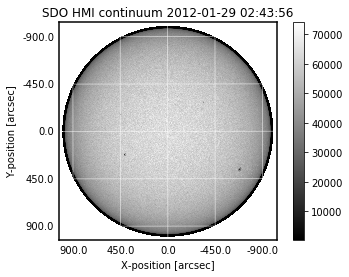

In [3]:
# Esto es para ver alguna imagen en específico, con coordenadas y todo
%matplotlib inline
# Making the map 
fitsfile = fits.open(basepath[0]+'/'+fits_files[14])
fitsfile.verify('fix')
data = fitsfile[1].data
header = fitsfile[1].header
m = Map((data, header))
m.peek()
# Set the colorbar properties.
#m.plot_settings['cmap'] = 'hmimag'
#m.plot_settings['norm'] = plt.Normalize(-1500, 1500)

In [ ]:
# Para dibujar perfiles
plt.plot(data[2048,:])
plt.xlabel('Pixeles')
plt.ylabel('Intensidad')
plt.grid(True)
plt.show()

# Widget to see time evolution

Since we are really dealing with a "big" sequence of images in FITS format it is helpful to have a widget to actually see the sequence and check wether the time range chosen is correct and see what to expect beforehand.

 [astropy.io.fits.verify]


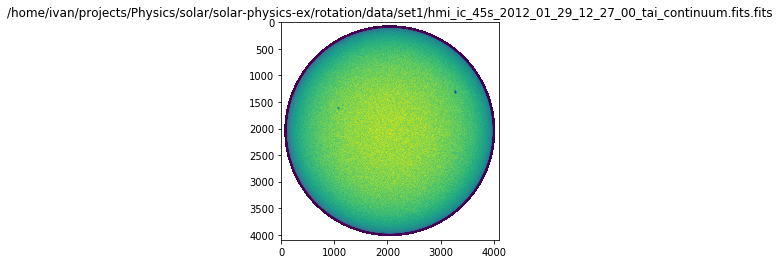

<function __main__.image_sequence>

In [4]:
%matplotlib inline
from IPython.html.widgets import *
number_of_images = len(fits_files)

def image_sequence(image):
    #fitsfile = fits.open(basepath[0]+'/data/'+fits_files[0])
    #print(fitsfile)
    fitsfile = fits.open(basepath[0]+'/'+fits_files[image])
    fitsfile.verify('fix')
    plt.imshow(fitsfile[1].data)
    plt.title(fitsfile.filename())
    plt.show()
    
interact(image_sequence, image=(0,number_of_images-1,1), continuous_update=False)

# Procesamiento de datos

Aplicaré algo de lo que dicen acá http://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/ para detectar manchas simultáneamente y hacer una estadística automática y "grande".

Tengo que aplicar lo de esa página pero con oscuros, no con claros. Por ahora se aplica a una imágen en específico, luego hay que aplicarla a todas las imágenes y que lance los datos de velocidad/trayectoria.

## Algoritmo:
En términos generales el algoritmo es como sigue:

1) Remover background/borde oscuro

2) Suavizar la imagen aplicando un filtro Gaussiano

3) "Binarizando" con umbral

4) Labeling the spots

5) Obteniendo centros de masa (en unidades arcsec)



In [5]:
# Módulos básicos para detectar contornos/manchas
from imutils import contours
from skimage import measure
import skimage
#import numpy as np
import imutils
import cv2

### 1) Remover background/borde oscuro, de medidas en casos anteriores sabemos que

3851 px = Diametro horizontal sol

3967 - 117 = 3850 px = Diametro vert. sol

Recordar que X -> vertical y Y -> horizontal, para tratamiento de imágenes.

La imagen es de 4096 x 4096 y si asumimos que la imagen está bien centrada en 2048, entonces podemos hacer un círculo de radio $r\le 3850/2 \approx 1920$ pixeles, tal que lo que esté por fuera de este círculo se vuelva "nan" y lo de adentro se quede igual.

Más información en: http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array

In [6]:
# Borrar background/contorno negro
## se hace una máscara circular con centro = (2048, 2048)
centerx, centery = 2048, 2048
r = 1920  # radius
y,x = np.ogrid[-centerx:4096-centerx, -centery:4096-centery]
mask = x*x + y*y > r*r  # circular mask
#array = np.ones((n, n))
#array[mask] = 255

In [7]:
# FUNCIONES BÁSICAS PARA HACER LO QUE NECESITO (deberían ir en un .py aparte - WIP)
# 
def extract_fits_data(index):
    '''
    Function to extract data from fitsfile given just an index
    '''
    fitsfile = fits.open(basepath[0]+'/'+fits_files[index])
    fitsfile.verify('fix')
    return fitsfile[1].header, fitsfile[1].data

In [ ]:
# Apply mask
header, data = extract_fits_data(14)
sun_map = Map((data, header))
data[mask] = 100000
# plot data to check background removal
%matplotlib inline
plt.figure()
plt.imshow(data)
plt.figure()
plt.imshow(extract_fits_data(14))
plt.show()

### 2) Suavizar la imagen aplicando un filtro Gaussiano

In [10]:
# Just blur the image with a gaussian filter
blurred = cv2.GaussianBlur(data, (31, 31), 0)

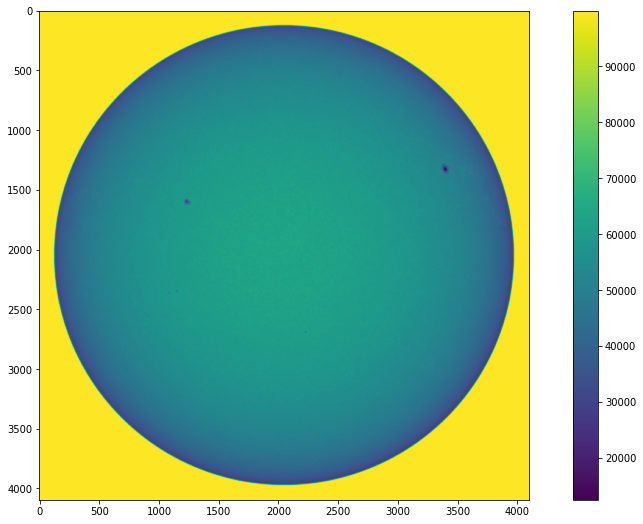

In [11]:
# Plot blurred image
%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(blurred)
plt.colorbar()
plt.show()

Al parecer usar 31 en el filtro Gaussiano da buenos resultados con esta imagen que tiene algunas manchas MUY pequeñas, de tal forma que puedo descartar todas las cosas que sean más brillantes a 4.5e4 (45000), detectando así solo las dos manchas grandes. Porque no puedo garantizar que las manchas pequeñas siempre sean visibles.

### 3) "Binarizando" con umbral

In [12]:
thresh = cv2.threshold(blurred, 28000, 74078, cv2.THRESH_BINARY)[1]

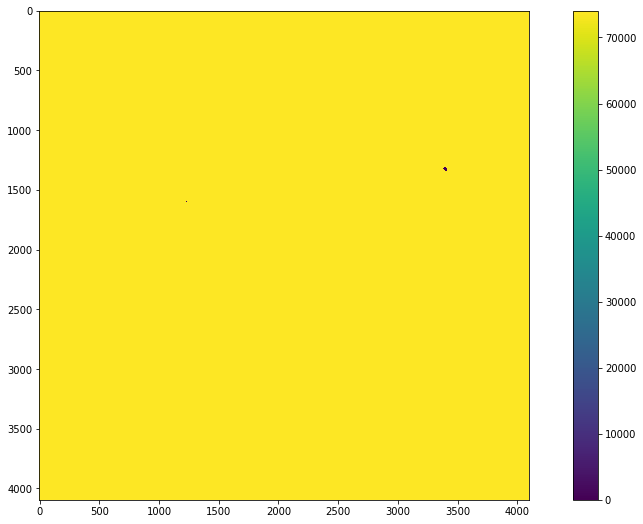

In [13]:
# Plot binary image
%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(thresh)
plt.colorbar()
plt.show()

In [ ]:
# Removing small "blobs" with erode and dilate
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

### 4) Labeling the spots
Using https://en.wikipedia.org/wiki/Connected-component_labeling

In [14]:
labels = measure.label(thresh, neighbors=8, background=74078)
mask = np.zeros(thresh.shape, dtype="uint8")
# loop over the unique components
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue
 
    # otherwise, construct the label mask and count the
    # number of pixels 
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 30:
        mask = cv2.add(mask, labelMask)

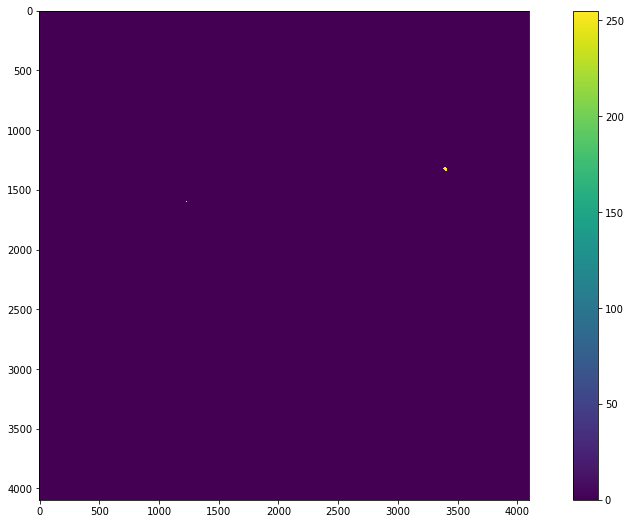

In [15]:
# Plot the resulting mask
# Plot binary image
%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(mask)
plt.colorbar()
plt.show()

In [ ]:
image = data.astype("uint8")
# find the contours in the mask, then sort them from left to right
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = contours.sort_contours(cnts)[0]
#cv2.namedWindow("Image", cv2.WINDOW_NORMAL or cv2.WINDOW_AUTOSIZE)  # To show window that's larger than screen 
# loop over the contours
centros_de_masa = []
for (i, c) in enumerate(cnts):
    # draw the bright spot on the image
    (x, y, w, h) = cv2.boundingRect(c)
    ((cX, cY), radius) = cv2.minEnclosingCircle(c)
    print(cX,cY)
    centros_de_masa.append([cX, cY])
    cv2.circle(image, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
    cv2.putText(image, "#{}".format(i + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# show the output image
#cv2.imshow("Image",image)
#cv2.waitKey(0)

### 5) Obteniendo centros de masa
De lo anterior se obtienen centros en pixeles, ahora tengo que pasar estos centros a centros de masa en coordenadas de sunpy (arcsec).

In [ ]:
# hago mapa de SunPy
sun_map = Map((data, header))

In [ ]:
for i in centros_de_masa:
    print(sun_map.pixel_to_data(i[0]*u.pix, i[1]*u.pix))

# Aplicando a todo el set
## Algoritmo:
En términos generales el algoritmo es como sigue:

1) Remover background/borde oscuro (aplicar máscara)

2) Suavizar la imagen aplicando un filtro Gaussiano

3) "Binarizando" con umbral

4) Labeling the spots

5) Obteniendo centros de masa (en unidades arcsec)

In [ ]:
def plot_data(data, title):
    %matplotlib inline
    plt.figure(figsize=(16,9))
    plt.title(title)
    plt.imshow(data)
    plt.colorbar()
    plt.show()

In [ ]:
number_of_spot = 1  # Initiliazing variable
centros_de_masa = 0 # Initializing variable

longitudes = []
latitudes = []
datetimes = []

#for imag_idx in range(1,140):  # For testing purposes
#for imag_idx in [1,140]:
for imag_idx in range(len(fits_files)):
    # 0) Extract header and data and make map
    header, data = extract_fits_data(imag_idx)
    sun_map = Map((data, header))
    
    # Prior to applying mask
    # Borrar background/contorno negro
    ## se hace una máscara circular con centro = (2048, 2048)
    centerx, centery = 2048, 2048
    r = 1920  # radius
    y,x = np.ogrid[-centerx:4096-centerx, -centery:4096-centery]
    mask = x*x + y*y > r*r  # circular mask
    #array = np.ones((n, n))
    #array[mask] = 255
        
    # 1) Apply mask
    data[mask] = 100000
    #plot_data(data, "data masked") # plot data masked
    
    # 2) Apply Gaussian filter
    blurred = cv2.GaussianBlur(data, (31, 31), 0)
    #plot_data(blurred, "data blurred") # plot data masked
    
    # 3) Binarizing
    thresh = cv2.threshold(blurred, 29250, 74078, cv2.THRESH_BINARY)[1]
    ## Removing small "blobs" with erode and dilate
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    #plot_data(thresh, "data binarized") # plot data masked
    
    # 4) Labeling and computing center in pixels
    labels = measure.label(thresh, neighbors=8, background=74078)
    mask = np.zeros(thresh.shape, dtype="uint8")
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue

        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > 30:
            mask = cv2.add(mask, labelMask)
    image = data.astype("uint8")
    # find the contours in the mask, then sort them from left to right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = contours.sort_contours(cnts)[0]
    #cv2.namedWindow("Image", cv2.WINDOW_NORMAL or cv2.WINDOW_AUTOSIZE)  # To show window that's larger than screen 
    # loop over the contours
    centros_de_masa_old = centros_de_masa
    centros_de_masa = []
    number_of_spot_old = number_of_spot
    for (number_of_spot, c) in enumerate(cnts):
        # draw the bright spot on the image
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        #print(cX,cY)
        centros_de_masa.append([cX, cY])
        cv2.circle(image, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
        cv2.putText(image, "#{}".format(number_of_spot + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    print("Detected ", number_of_spot+1, " spots.")
    if number_of_spot_old != number_of_spot:
        print("Last index image calculated: ", imag_idx)
        raise ValueError("Number of spots detected differente from before. Stoping calculation.")
        
    # 5) Getting centers of mass in lat,long (arcsecs)
    # hago mapa de SunPy
    #sun_map = Map((data, header))
    longitude_temp = []
    latitude_temp = []
    for CoM in centros_de_masa:    
        longitude, latitude = sun_map.pixel_to_data(CoM[0]*u.pix, CoM[1]*u.pix)
        longitude_temp.append(longitude)
        latitude_temp.append(latitude)
        #print(longitude, latitude)
    #print(longitude_temp)
    longitudes.append(longitude_temp)
    latitudes.append(latitude_temp)
    datetimes.append(sun_map.date)
    
        
    # Borrar todas las variables para evitar errores
    del(sun_map, header, mask, data, blurred, thresh, image, longitude_temp)

In [ ]:
# Volver arreglos de tiempos, latitudes, longitudes un arreglo numérico
deltatimes = []
longitudes_0 = []
longitudes_1 = []
latitudes_0 = []
latitudes_1 = []
for i in range(len(datetimes)-1):
    delta_t = datetimes[i+1] - datetimes[i]
    print(datetimes[i+1], " - ", datetimes[i]," = ", delta_t)
    deltatimes.append(delta_t.seconds)
for i in range(len(longitudes)-1):
    delta_long_0 = longitudes[i+1][0] - longitudes[i][0]
    delta_long_1 = longitudes[i+1][1] - longitudes[i][1]
    longitudes_0.append(delta_long_0.arcsec)
    longitudes_1.append(delta_long_1.arcsec)
    
deltatimes = np.array(deltatimes)
longitudes_0 = np.array(longitudes_0)
longitudes_1 = np.array(longitudes_1)


In [ ]:
# Computing instantaneous angular velocities
v0 = []
v1 = []
for i in range(np.size(longitudes_0)):
    v0.append(longitudes_0[i]/deltatimes[i])
    v1.append(longitudes_1[i]/deltatimes[i])
v0 = np.array(v0)
v1 = np.array(v1)